In [1]:
import os
import random
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib . pyplot as plt
from PIL import Image

In [2]:
ROOT = './data'
train_data = datasets.MNIST(root=ROOT, train=True, download=True)
test_data = datasets.MNIST(root=ROOT, train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:09<00:00, 1037494.87it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 47073.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:07<00:00, 226761.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 13824766.89it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# split training : validation = 0.9 : 0.1
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

# compute mean and std for normalization
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

# Create dataloader
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)


In [4]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs


In [6]:
import time
import torch

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print("| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}".format(epoch, idx, len(train_dataloader), total_acc / total_count))

            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


In [7]:
# Evaluation function
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


In [9]:
import torch
import time

import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of classes
num_classes = len(train_data.dataset.classes)

# Create the LeNet model
lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

# Set the number of epochs and save model path
num_epochs = 10
save_model = './model'

# Initialize lists for train accuracy and loss, and evaluation accuracy and loss
train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

# Training and evaluation loop
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()

    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), f'{save_model}/lenet_model.pt')
        best_loss_eval = eval_loss

    # Print end of epoch results
    print("-" * 59)
    print(f"| End of epoch {epoch:3d} | Time: {time.time() - epoch_start_time:.2f}s | "
          f"Train Accuracy: {train_acc:.3f} | Train Loss: {train_loss:.3f} | "
          f"Valid Accuracy: {eval_acc:.3f} | Valid Loss: {eval_loss:.3f}")
    print("-" * 59)

# Load the best model
lenet_model.load_state_dict(torch.load(f'{save_model}/lenet_model.pt'))
lenet_model.eval()

| epoch   1 |    50/  211 batches | accuracy    0.681
| epoch   1 |   100/  211 batches | accuracy    0.881
| epoch   1 |   150/  211 batches | accuracy    0.909
| epoch   1 |   200/  211 batches | accuracy    0.926
-----------------------------------------------------------
| End of epoch   1 | Time: 6.45s | Train Accuracy: 0.942 | Train Loss: 0.505 | Valid Accuracy: 0.933 | Valid Loss: 0.217
-----------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.951
| epoch   2 |   100/  211 batches | accuracy    0.960
| epoch   2 |   150/  211 batches | accuracy    0.962
| epoch   2 |   200/  211 batches | accuracy    0.968
-----------------------------------------------------------
| End of epoch   2 | Time: 6.38s | Train Accuracy: 0.970 | Train Loss: 0.131 | Valid Accuracy: 0.972 | Valid Loss: 0.109
-----------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.972
| epoch   3 |   100/  211 batche

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

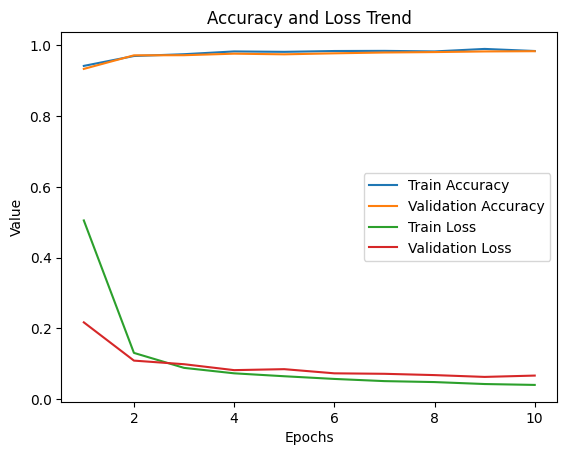

In [10]:
import matplotlib.pyplot as plt

# Define the number of epochs
num_epochs = len(train_accs)

# Create x-axis values for epochs
epochs = range(1, num_epochs + 1)

# Plot accuracy
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, eval_accs, label='Validation Accuracy')

# Plot loss
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, eval_losses, label='Validation Loss')

# Set plot title and labels
plt.title('Accuracy and Loss Trend')
plt.xlabel('Epochs')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show the plot
plt.show()